## Classificador de Intenções LSTM 

### Large LSTM 

* Categorical label

In [1]:

import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# ===== Dataset sintético =====

df = pd.read_csv('dataset_bancario_expandido.csv')
df.rename(columns={"frase": "texto", "label": "classe"}, inplace=True)
df.head()


,texto,classe
0,"Lançar cobrança para João no valor de R$ 3399,97",Cobrança
1,Gerar cobrança automática de R$ 3108,Cobrança
2,Cobrar R$ 4554 à vista amanhã,Cobrança
3,"Passe a cobrança de R$ 9,50 para o cliente",Cobrança
4,Cobrar R$ 541 à vista amanhã,Cobrança


In [3]:
df.shape

(2000, 2)

In [4]:
# Codificação das labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["classe"])
df.head()

,texto,classe,label
0,"Lançar cobrança para João no valor de R$ 3399,97",Cobrança,0
1,Gerar cobrança automática de R$ 3108,Cobrança,0
2,Cobrar R$ 4554 à vista amanhã,Cobrança,0
3,"Passe a cobrança de R$ 9,50 para o cliente",Cobrança,0
4,Cobrar R$ 541 à vista amanhã,Cobrança,0


## Stemming

In [5]:
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.corpus import wordnet as wn
from tensorflow.keras.preprocessing.text import one_hot
from nltk.stem import RSLPStemmer


nltk.download('rslp')
nltk.download('stopwords')

#print(train_data)
# StopWords
stopwords_pt = set(stopwords.words('portuguese'))

stemmer = RSLPStemmer()

# to lower case
df['texto_tratado'] = df['texto'].str.lower()

for index, entry in enumerate(df['texto_tratado']):
    tokens = nltk.word_tokenize(entry, language='portuguese') 
    #print(tagged)
    final_words = []
    # Tagging is extra processing with no effect in results
    for word in tokens:
        if word not in stopwords_pt and word.isalpha():
            final_words.append(stemmer.stem(word))

    df.loc[index, 'texto_final_stem'] = ' '.join(final_words)


[nltk_data] Downloading package rslp to
[nltk_data]     /Users/felipemenezes/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/felipemenezes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df[df['label'] == 1].head()

,texto,classe,label,texto_tratado,texto_final_stem
1000,Verificar saldo em conta conjunta,Consulta Saldo,1,verificar saldo em conta conjunta,verific sald cont conjunt
1001,Consultar saldo atualizado,Consulta Saldo,1,consultar saldo atualizado,consult sald atual
1002,Consultar saldo atualizado,Consulta Saldo,1,consultar saldo atualizado,consult sald atual
1003,Consultar quanto tenho no banco,Consulta Saldo,1,consultar quanto tenho no banco,consult quant banc
1004,Mostrar saldo bancário,Consulta Saldo,1,mostrar saldo bancário,mostr sald banc


In [7]:
df[df['label'] == 3].head()

,texto,classe,label,texto_tratado,texto_final_stem
500,"Pagar boleto no valor de R$ 449,52",Pagamento,3,"pagar boleto no valor de r$ 449,52",pag bolet val r
501,"Transferir R$ 3953,23 para a conta poupança",Pagamento,3,"transferir r$ 3953,23 para a conta poupança",transfer r cont poupanç
502,"Transferir R$ 1308,25 para Maria",Pagamento,3,"transferir r$ 1308,25 para maria",transfer r mar
503,Realizar transferência de R$ 4727 para Pedro,Pagamento,3,realizar transferência de r$ 4727 para pedro,realiz transfer r pedr
504,"Efetuar o pagamento da assinatura de R$ 4265,23",Pagamento,3,"efetuar o pagamento da assinatura de r$ 4265,23",efetu pag assinat r


In [8]:
df[df['label'] == 0].head()

,texto,classe,label,texto_tratado,texto_final_stem
0,"Lançar cobrança para João no valor de R$ 3399,97",Cobrança,0,"lançar cobrança para joão no valor de r$ 3399,97",lanç cobranç joã val r
1,Gerar cobrança automática de R$ 3108,Cobrança,0,gerar cobrança automática de r$ 3108,ger cobranç automá r
2,Cobrar R$ 4554 à vista amanhã,Cobrança,0,cobrar r$ 4554 à vista amanhã,cobr r vist amanhã
3,"Passe a cobrança de R$ 9,50 para o cliente",Cobrança,0,"passe a cobrança de r$ 9,50 para o cliente",pass cobranç r client
4,Cobrar R$ 541 à vista amanhã,Cobrança,0,cobrar r$ 541 à vista amanhã,cobr r vist amanhã


In [9]:
df[df['label'] == 2].head()

,texto,classe,label,texto_tratado,texto_final_stem
1500,Solicitar orçamento de compra,Outro,2,solicitar orçamento de compra,solic orç compr
1501,Agendar revisão do carro,Outro,2,agendar revisão do carro,agend revis carr
1502,Organizar documentos do escritório,Outro,2,organizar documentos do escritório,organiz document escritóri
1503,Confirmar presença no evento,Outro,2,confirmar presença no evento,confirm presenç event
1504,Pedir orçamento para reforma,Outro,2,pedir orçamento para reforma,ped orç reform


In [10]:
# Remove duplicates 
print(df.shape)
df_stem = df.drop_duplicates(subset=['texto_final_stem'])
df_stem.shape

(2000, 5)


(48, 5)

In [11]:
from tensorflow.keras.utils import to_categorical
# ===== 2. Tokenização =====
vocab_size = 5000
tokenizer2 = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer2.fit_on_texts(df["texto_final_stem"])
sequences = tokenizer2.texts_to_sequences(df["texto_final_stem"])
max_len = int(np.percentile([len(s) for s in sequences], 95))
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = df["label"].values
#print(y)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train_cat = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test_cat  = to_categorical(y_test, num_classes=len(label_encoder.classes_))

print(X_train.shape)
print(y_train_cat.shape)

(1400, 5)
(1400, 4)


In [12]:

# ===== Modelo LSTM =====
voc_size = len(tokenizer2.word_index) + 1
embedding_vector_features = 40

print(X_train.shape)
print(len(label_encoder.classes_))
print(y_train.shape)
# From Medium

model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, trainable=False, input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.build(input_shape=(None, len(label_encoder.classes_)))
print(model.summary())

# ===== Treino =====
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=15,
    batch_size=64,shuffle=True
)

(1400, 5)
4
(1400,)


/Users/felipemenezes/Codes/pythonEnvs/machine/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-09-02 20:45:47.357239: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-09-02 20:45:47.357267: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-02 20:45:47.357270: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1756856747.357281 7329014 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1756856747.357301 7329014 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 4, 40)          │         3,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 4, 128)         │        53,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,942 (429.46 KB)

 Trainable params: 106,622 (416.49 KB)

 Non-trainable params: 3,320 (12.97 KB)

None
Epoch 1/15


2025-09-02 20:45:49.259348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 372ms/step - acc: 0.2869 - loss: 1.3826 - val_acc: 0.5733 - val_loss: 1.3508
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - acc: 0.5609 - loss: 1.2976 - val_acc: 0.6533 - val_loss: 0.9325
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - acc: 0.6072 - loss: 0.8345 - val_acc: 0.8183 - val_loss: 0.5985
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - acc: 0.7108 - loss: 0.5963 - val_acc: 0.8900 - val_loss: 0.3067
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - acc: 0.9192 - loss: 0.2821 - val_acc: 0.9467 - val_loss: 0.1261
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - acc: 0.9569 - loss: 0.1299 - val_acc: 1.0000 - val_loss: 0.0139
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step - acc: 0.9844 - loss: 0.0526 - val_acc: 1.0000 - val_loss: 0.0024
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - acc: 0.9944 - loss: 0.0261 - val_acc: 1.0000 - val_loss: 0.0015
Epoch 9/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - acc: 0.9898 

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


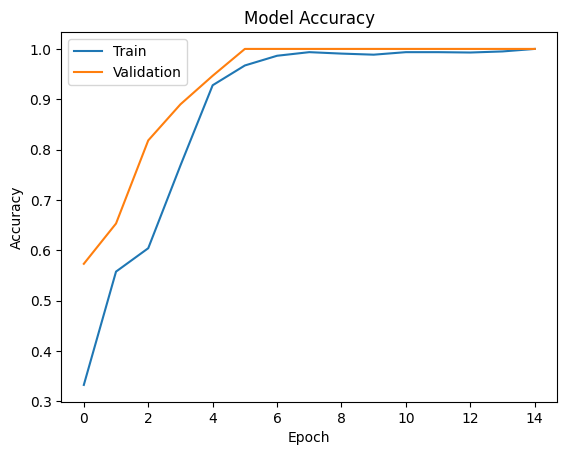

In [13]:
print(history)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:

# ===== 7. Avaliação =====
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"\nAcurácia no teste: {acc:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - acc: 1.0000 - loss: 1.0472e-04

Acurácia no teste: 1.0000


In [15]:
# ===== 8. Testando previsão =====
nova_frase = ["consulte meu saldo".lower()]
nova_frase = [word_tokenize(entry, language='portuguese') for entry in nova_frase]

final_words = []
for word in nova_frase[0]:
        if word not in stopwords_pt and word.isalpha():
            final_words.append(stemmer.stem(word))

print(final_words)

seq = tokenizer2.texts_to_sequences([final_words])
padded = pad_sequences(seq, maxlen=max_len, padding='post')

# Faz predição
pred = model.predict(padded)[0] 

print(pred)

# Obtém índice da classe com maior probabilidade
classe_idx = np.argmax(pred)
prob = pred[classe_idx]

print(prob)

print("\nFrase:", nova_frase[0])
print("Classe prevista:", label_encoder.inverse_transform([classe_idx]))
print("Probabilidade:", prob)

['consult', 'sald']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[2.7216982e-08 9.9987924e-01 1.2051841e-04 2.4123111e-07]
0.99987924

Frase: ['consulte', 'meu', 'saldo']
Classe prevista: ['Consulta Saldo']
Probabilidade: 0.99987924


In [16]:

# ==== Dataset de teste ====
dataset2 = [
    ("Pagar conta de luz", None),
    ("Trasferir R$5", None),
    ("Informe meu saldo", None),
    ("Cobra dez reais", None),
    ("me diga o meu saldo", None),
    ("passe um valor de R$50,00", None),
    ("transfirir R$3,99", None)
]
dfSample = pd.DataFrame(dataset2, columns=["texto", "classe_pred"])



In [17]:
def prever_classe(texto):
    frase_proc = word_tokenize(texto.lower(), language='portuguese')
    
    final_words = [
        stemmer.stem(word) 
        for word in frase_proc 
        if word not in stopwords_pt and word.isalpha()
    ]
    
    # Sequência → padding
    seq = tokenizer2.texts_to_sequences([final_words])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    
    # Predição
    pred = model.predict(padded, verbose=0)[0]
    classe_idx = np.argmax(pred)
    prob = pred[classe_idx]
    classe = label_encoder.inverse_transform([classe_idx])[0]
    return classe, prob


In [18]:
# ==== Preencher previsões ====
dfSample["classe_pred"] = dfSample["texto"].apply(
    lambda x: prever_classe(x)[0]
)
dfSample["probabilidade"] = dfSample["texto"].apply(
    lambda x: prever_classe(x)[1]
)

print(dfSample)

                       texto     classe_pred  probabilidade
0         Pagar conta de luz  Consulta Saldo       0.945090
1              Trasferir R$5  Consulta Saldo       0.638415
2          Informe meu saldo  Consulta Saldo       0.999885
3            Cobra dez reais        Cobrança       0.980723
4        me diga o meu saldo  Consulta Saldo       0.999885
5  passe um valor de R$50,00        Cobrança       0.999993
6          transfirir R$3,99  Consulta Saldo       0.638415


## Confusion Matrix

In [19]:
y_pred1=np.argmax(model.predict(X_test), axis=-1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred1)

1.0

(<Figure size 500x500 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

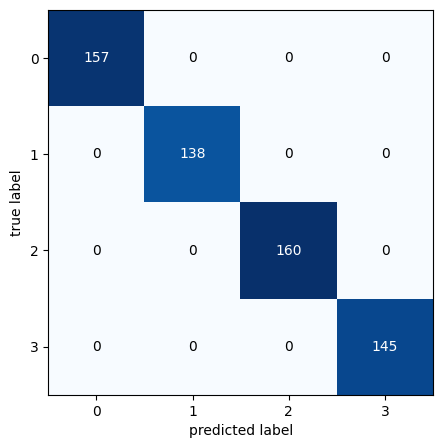

In [21]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm= confusion_matrix(y_test,y_pred1)
plot_confusion_matrix(cm, figsize=(5,5))

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred1, target_names=label_encoder.classes_))

                precision    recall  f1-score   support

      Cobrança       1.00      1.00      1.00       157
Consulta Saldo       1.00      1.00      1.00       138
         Outro       1.00      1.00      1.00       160
     Pagamento       1.00      1.00      1.00       145

      accuracy                           1.00       600
     macro avg       1.00      1.00      1.00       600
  weighted avg       1.00      1.00      1.00       600



## Extraindo Intenção Completa 

In [23]:
import re
# Funções regex
def extrair_valor(texto):
    match = re.search(r'R\$\s?([\d\.,]+)', texto)
    if match:
        valor = match.group(1).replace('.', '').replace(',', '.')
        return float(valor)
    return None

def extrair_parcelas(texto):
    match = re.search(r'(\d+)[xX]', texto)
    if match:
        return int(match.group(1))
    return None


In [24]:
dfSample["valor"] = dfSample["texto"].apply(
    lambda x: extrair_valor(x)
)

print(dfSample)

                       texto     classe_pred  probabilidade  valor
0         Pagar conta de luz  Consulta Saldo       0.945090    NaN
1              Trasferir R$5  Consulta Saldo       0.638415   5.00
2          Informe meu saldo  Consulta Saldo       0.999885    NaN
3            Cobra dez reais        Cobrança       0.980723    NaN
4        me diga o meu saldo  Consulta Saldo       0.999885    NaN
5  passe um valor de R$50,00        Cobrança       0.999993  50.00
6          transfirir R$3,99  Consulta Saldo       0.638415   3.99


## Save Model

In [25]:
model.save("sematica_lstm2.h5")